In [92]:
#!/usr/bin/env python
###############################################################################
# $Id$
#
# Project:  GDAL2Tiles, Google Summer of Code 2007 & 2008
#           Global Map Tiles Classes
# Purpose:  Convert a raster into TMS tiles, create KML SuperOverlay EPSG:4326,
#           generate a simple HTML viewers based on Google Maps and OpenLayers
# Author:   Klokan Petr Pridal, klokan at klokan dot cz
# Web:      http://www.klokan.cz/projects/gdal2tiles/
#
###############################################################################
# Copyright (c) 2008 Klokan Petr Pridal. All rights reserved.
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included
# in all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS
# OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
###############################################################################

"""
globalmaptiles.py
Global Map Tiles as defined in Tile Map Service (TMS) Profiles
==============================================================
Functions necessary for generation of global tiles used on the web.
It contains classes implementing coordinate conversions for:
  - GlobalMercator (based on EPSG:900913 = EPSG:3785)
       for Google Maps, Yahoo Maps, Microsoft Maps compatible tiles
  - GlobalGeodetic (based on EPSG:4326)
       for OpenLayers Base Map and Google Earth compatible tiles
More info at:
http://wiki.osgeo.org/wiki/Tile_Map_Service_Specification
http://wiki.osgeo.org/wiki/WMS_Tiling_Client_Recommendation
http://msdn.microsoft.com/en-us/library/bb259689.aspx
http://code.google.com/apis/maps/documentation/overlays.html#Google_Maps_Coordinates
Created by Klokan Petr Pridal on 2008-07-03.
Google Summer of Code 2008, project GDAL2Tiles for OSGEO.
In case you use this class in your product, translate it to another language
or find it usefull for your project please let me know.
My email: klokan at klokan dot cz.
I would like to know where it was used.
Class is available under the open-source GDAL license (www.gdal.org).
"""

import math

class GlobalMercator(object):
    """
    TMS Global Mercator Profile
    ---------------------------
    Functions necessary for generation of tiles in Spherical Mercator projection,
    EPSG:900913 (EPSG:gOOglE, Google Maps Global Mercator), EPSG:3785, OSGEO:41001.
    Such tiles are compatible with Google Maps, Microsoft Virtual Earth, Yahoo Maps,
    UK Ordnance Survey OpenSpace API, ...
    and you can overlay them on top of base maps of those web mapping applications.
    
    Pixel and tile coordinates are in TMS notation (origin [0,0] in bottom-left).
    What coordinate conversions do we need for TMS Global Mercator tiles::
         LatLon      <->       Meters      <->     Pixels    <->       Tile     
     WGS84 coordinates   Spherical Mercator  Pixels in pyramid  Tiles in pyramid
         lat/lon            XY in metres     XY pixels Z zoom      XYZ from TMS 
        EPSG:4326           EPSG:900913                                         
         .----.              ---------               --                TMS      
        /      \     <->     |       |     <->     /----/    <->      Google    
        \      /             |       |           /--------/          QuadTree   
         -----               ---------         /------------/                   
       KML, public         WebMapService         Web Clients      TileMapService
    What is the coordinate extent of Earth in EPSG:900913?
      [-20037508.342789244, -20037508.342789244, 20037508.342789244, 20037508.342789244]
      Constant 20037508.342789244 comes from the circumference of the Earth in meters,
      which is 40 thousand kilometers, the coordinate origin is in the middle of extent.
      In fact you can calculate the constant as: 2 * math.pi * 6378137 / 2.0
      $ echo 180 85 | gdaltransform -s_srs EPSG:4326 -t_srs EPSG:900913
      Polar areas with abs(latitude) bigger then 85.05112878 are clipped off.
    What are zoom level constants (pixels/meter) for pyramid with EPSG:900913?
      whole region is on top of pyramid (zoom=0) covered by 256x256 pixels tile,
      every lower zoom level resolution is always divided by two
      initialResolution = 20037508.342789244 * 2 / 256 = 156543.03392804062
    What is the difference between TMS and Google Maps/QuadTree tile name convention?
      The tile raster itself is the same (equal extent, projection, pixel size),
      there is just different identification of the same raster tile.
      Tiles in TMS are counted from [0,0] in the bottom-left corner, id is XYZ.
      Google placed the origin [0,0] to the top-left corner, reference is XYZ.
      Microsoft is referencing tiles by a QuadTree name, defined on the website:
      http://msdn2.microsoft.com/en-us/library/bb259689.aspx
    The lat/lon coordinates are using WGS84 datum, yeh?
      Yes, all lat/lon we are mentioning should use WGS84 Geodetic Datum.
      Well, the web clients like Google Maps are projecting those coordinates by
      Spherical Mercator, so in fact lat/lon coordinates on sphere are treated as if
      the were on the WGS84 ellipsoid.
     
      From MSDN documentation:
      To simplify the calculations, we use the spherical form of projection, not
      the ellipsoidal form. Since the projection is used only for map display,
      and not for displaying numeric coordinates, we don't need the extra precision
      of an ellipsoidal projection. The spherical projection causes approximately
      0.33 percent scale distortion in the Y direction, which is not visually noticable.
    How do I create a raster in EPSG:900913 and convert coordinates with PROJ.4?
      You can use standard GIS tools like gdalwarp, cs2cs or gdaltransform.
      All of the tools supports -t_srs 'epsg:900913'.
      For other GIS programs check the exact definition of the projection:
      More info at http://spatialreference.org/ref/user/google-projection/
      The same projection is degined as EPSG:3785. WKT definition is in the official
      EPSG database.
      Proj4 Text:
        +proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0
        +k=1.0 +units=m +nadgrids=@null +no_defs
      Human readable WKT format of EPGS:900913:
         PROJCS["Google Maps Global Mercator",
             GEOGCS["WGS 84",
                 DATUM["WGS_1984",
                     SPHEROID["WGS 84",6378137,298.2572235630016,
                         AUTHORITY["EPSG","7030"]],
                     AUTHORITY["EPSG","6326"]],
                 PRIMEM["Greenwich",0],
                 UNIT["degree",0.0174532925199433],
                 AUTHORITY["EPSG","4326"]],
             PROJECTION["Mercator_1SP"],
             PARAMETER["central_meridian",0],
             PARAMETER["scale_factor",1],
             PARAMETER["false_easting",0],
             PARAMETER["false_northing",0],
             UNIT["metre",1,
                 AUTHORITY["EPSG","9001"]]]
    """

    def __init__(self, tileSize=256):
        "Initialize the TMS Global Mercator pyramid"
        self.tileSize = tileSize
        self.initialResolution = 2 * math.pi * 6378137 / self.tileSize
        # 156543.03392804062 for tileSize 256 pixels
        self.originShift = 2 * math.pi * 6378137 / 2.0
        # 20037508.342789244

    def LatLonToMeters(self, lat, lon ):
        "Converts given lat/lon in WGS84 Datum to XY in Spherical Mercator EPSG:900913"

        mx = lon * self.originShift / 180.0
        my = math.log( math.tan((90 + lat) * math.pi / 360.0 )) / (math.pi / 180.0)

        my = my * self.originShift / 180.0
        return mx, my

    def MetersToLatLon(self, mx, my ):
        "Converts XY point from Spherical Mercator EPSG:900913 to lat/lon in WGS84 Datum"

        lon = (mx / self.originShift) * 180.0
        lat = (my / self.originShift) * 180.0

        lat = 180 / math.pi * (2 * math.atan( math.exp( lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    def PixelsToMeters(self, px, py, zoom):
        "Converts pixel coordinates in given zoom level of pyramid to EPSG:900913"

        res = self.Resolution( zoom )
        mx = px * res - self.originShift
        my = py * res - self.originShift
        return mx, my
        
    def MetersToPixels(self, mx, my, zoom):
        "Converts EPSG:900913 to pyramid pixel coordinates in given zoom level"
                
        res = self.Resolution( zoom )
        px = (mx + self.originShift) / res
        py = (my + self.originShift) / res
        return px, py
    
    def PixelsToTile(self, px, py):
        "Returns a tile covering region in given pixel coordinates"

        tx = int( math.ceil( px / float(self.tileSize) ) - 1 )
        ty = int( math.ceil( py / float(self.tileSize) ) - 1 )
        return tx, ty

    def PixelsToRaster(self, px, py, zoom):
        "Move the origin of pixel coordinates to top-left corner"
        
        mapSize = self.tileSize << zoom
        return px, mapSize - py
        
    def MetersToTile(self, mx, my, zoom):
        "Returns tile for given mercator coordinates"
        
        px, py = self.MetersToPixels( mx, my, zoom)
        return self.PixelsToTile( px, py)

    def TileBounds(self, tx, ty, zoom):
        "Returns bounds of the given tile in EPSG:900913 coordinates"
        
        minx, miny = self.PixelsToMeters( tx*self.tileSize, ty*self.tileSize, zoom )
        maxx, maxy = self.PixelsToMeters( (tx+1)*self.tileSize, (ty+1)*self.tileSize, zoom )
        return ( minx, miny, maxx, maxy )

    def TileLatLonBounds(self, tx, ty, zoom ):
        "Returns bounds of the given tile in latutude/longitude using WGS84 datum"

        bounds = self.TileBounds( tx, ty, zoom)
        minLat, minLon = self.MetersToLatLon(bounds[0], bounds[1])
        maxLat, maxLon = self.MetersToLatLon(bounds[2], bounds[3])
         
        return ( minLat, minLon, maxLat, maxLon )
        
    def Resolution(self, zoom ):
        "Resolution (meters/pixel) for given zoom level (measured at Equator)"
        
        # return (2 * math.pi * 6378137) / (self.tileSize * 2**zoom)
        return self.initialResolution / (2**zoom)
        
    def ZoomForPixelSize(self, pixelSize ):
        "Maximal scaledown zoom of the pyramid closest to the pixelSize."
        
        for i in range(30):
            if pixelSize > self.Resolution(i):
                return i-1 if i!=0 else 0 # We don't want to scale up

    def GoogleTile(self, tx, ty, zoom):
        "Converts TMS tile coordinates to Google Tile coordinates"
        
        # coordinate origin is moved from bottom-left to top-left corner of the extent
        return tx, (2**zoom - 1) - ty

    def QuadTree(self, tx, ty, zoom ):
        "Converts TMS tile coordinates to Microsoft QuadTree"
        
        quadKey = ""
        ty = (2**zoom - 1) - ty
        for i in range(zoom, 0, -1):
            digit = 0
            mask = 1 << (i-1)
            if (tx & mask) != 0:
                digit += 1
            if (ty & mask) != 0:
                digit += 2
            quadKey += str(digit)
            
        return quadKey

#---------------------

class GlobalGeodetic(object):
    """
    TMS Global Geodetic Profile
    ---------------------------
    Functions necessary for generation of global tiles in Plate Carre projection,
    EPSG:4326, "unprojected profile".
    Such tiles are compatible with Google Earth (as any other EPSG:4326 rasters)
    and you can overlay the tiles on top of OpenLayers base map.
    
    Pixel and tile coordinates are in TMS notation (origin [0,0] in bottom-left).
    What coordinate conversions do we need for TMS Global Geodetic tiles?
      Global Geodetic tiles are using geodetic coordinates (latitude,longitude)
      directly as planar coordinates XY (it is also called Unprojected or Plate
      Carre). We need only scaling to pixel pyramid and cutting to tiles.
      Pyramid has on top level two tiles, so it is not square but rectangle.
      Area [-180,-90,180,90] is scaled to 512x256 pixels.
      TMS has coordinate origin (for pixels and tiles) in bottom-left corner.
      Rasters are in EPSG:4326 and therefore are compatible with Google Earth.
         LatLon      <->      Pixels      <->     Tiles     
     WGS84 coordinates   Pixels in pyramid  Tiles in pyramid
         lat/lon         XY pixels Z zoom      XYZ from TMS 
        EPSG:4326                                           
         .----.                ----                         
        /      \     <->    /--------/    <->      TMS      
        \      /         /--------------/                   
         -----        /--------------------/                
       WMS, KML    Web Clients, Google Earth  TileMapService
    """

    def __init__(self, tileSize = 256):
        self.tileSize = tileSize

    def LatLonToPixels(self, lat, lon, zoom):
        "Converts lat/lon to pixel coordinates in given zoom of the EPSG:4326 pyramid"

        res = 180 / 256.0 / 2**zoom
        px = (180 + lat) / res
        py = (90 + lon) / res
        return px, py

    def PixelsToTile(self, px, py):
        "Returns coordinates of the tile covering region in pixel coordinates"

        tx = int( math.ceil( px / float(self.tileSize) ) - 1 )
        ty = int( math.ceil( py / float(self.tileSize) ) - 1 )
        return tx, ty

    def Resolution(self, zoom ):
        "Resolution (arc/pixel) for given zoom level (measured at Equator)"
        
        return 180 / 256.0 / 2**zoom
        #return 180 / float( 1 << (8+zoom) )

    def TileBounds(tx, ty, zoom):
        "Returns bounds of the given tile"
        res = 180 / 256.0 / 2**zoom
        return (
            tx*256*res - 180,
            ty*256*res - 90,
            (tx+1)*256*res - 180,
            (ty+1)*256*res - 90
        )

if __name__ == "__main__":
    import sys, os
        
    def Usage(s = ""):
        print(s)

    profile = 'mercator'
    zoomlevel = None
    lat, lon, latmax, lonmax = None, None, None, None
    boundingbox = False

def explain_bbox_to_tiles(boundingbox, zoomlevel):
    lat, lon, latmax, lonmax = boundingbox
    profile = 'mercator'
    
    if latmax != None and lonmax != None:
        if latmax < lat:
            Usage("ERROR: 'latmax' must be bigger then 'lat'")
        if lonmax < lon:
            Usage("ERROR: 'lonmax' must be bigger then 'lon'")
        boundingbox = (lon, lat, lonmax, latmax)
    
    tz = zoomlevel
    mercator = GlobalMercator()

    mx, my = mercator.LatLonToMeters( lat, lon )
    print("Spherical Mercator (ESPG:900913) coordinates for lat/lon: ")
    print(mx, my)
    tminx, tminy = mercator.MetersToTile( mx, my, tz )
    
    mx, my = mercator.LatLonToMeters( latmax, lonmax )
    print("Spherical Mercator (ESPG:900913) cooridnate for maxlat/maxlon: ")
    print(mx, my)
    tmaxx, tmaxy = mercator.MetersToTile( mx, my, tz )

        
    for ty in range(tminy, tmaxy+1):
        for tx in range(tminx, tmaxx+1):
            tilefilename = "%s/%s/%s" % (tz, tx, ty)
            print(tilefilename, "( TileMapService: z / x / y )")
        
            gx, gy = mercator.GoogleTile(tx, ty, tz)
            print("\tGoogle:", gx, gy)
            quadkey = mercator.QuadTree(tx, ty, tz)
            print("\tQuadkey:", quadkey, '(',int(quadkey, 4),')')
            bounds = mercator.TileBounds( tx, ty, tz)
            print()
            print("\tEPSG:900913 Extent: ", bounds)
            wgsbounds = mercator.TileLatLonBounds( tx, ty, tz)
            print("\tWGS84 Extent:", wgsbounds)
            print("\tgdalwarp -ts 256 256 -te %s %s %s %s %s %s_%s_%s.tif" % (
                bounds[0], bounds[1], bounds[2], bounds[3], "<your-raster-file-in-epsg900913.ext>", tz, tx, ty))

def bbox_to_tiles(boundingbox, zoomlevel):    
    lat, lon, latmax, lonmax = boundingbox
    tz = zoomlevel
    mercator = GlobalMercator()
    
    mx, my = mercator.LatLonToMeters( lat, lon )
    tminx, tminy = mercator.MetersToTile( mx, my, tz )
    
    mx, my = mercator.LatLonToMeters( latmax, lonmax )
    tmaxx, tmaxy = mercator.MetersToTile( mx, my, tz )

    for ty in range(tminy, tmaxy+1):
        for tx in range(tminx, tmaxx+1):
            yield dict(
                tilefilename = f"{tz}/{tx}/{ty}",
                mercator = mercator.GoogleTile(tx, ty, tz),
                google_quadkey = mercator.QuadTree(tx, ty, tz),
                EPSG_900913_bounds = mercator.TileBounds( tx, ty, tz),
                WGS84_bounds = mercator.TileLatLonBounds( tx, ty, tz),
            )

In [93]:
mercator = GlobalMercator()

def WGS84bbox_to_enclosing_tile_bbox(bbox, zoomlevel):
    lat, lon, latmax, lonmax = bbox
    tz = zoomlevel
    
    mx, my = mercator.LatLonToMeters( lat, lon )
    tminx, tminy = mercator.MetersToTile( mx, my, tz )
    
    mx, my = mercator.LatLonToMeters( latmax, lonmax )
    tmaxx, tmaxy = mercator.MetersToTile( mx, my, tz )
    
    return tminx, tminy, tmaxx, tmaxy
    

def enumerate_tiles(bbox, zoomlevel):    
    tminx, tminy, tmaxx, tmaxy = bbox
    tz = zoomlevel
    for ty in range(tminy, tmaxy+1):
        for tx in range(tminx, tmaxx+1):
            yield dict(
                tilefilename = f"{tz}/{tx}/{ty}",
                mercator = mercator.GoogleTile(tx, ty, tz),
                google_quadkey = mercator.QuadTree(tx, ty, tz),
                EPSG_900913_bounds = mercator.TileBounds( tx, ty, tz),
                WGS84_bounds = mercator.TileLatLonBounds( tx, ty, tz),
            )

region_of_interest_WGS84bbox_bbox = (-20.830078,39.571822,25.664063,59.756395)
zoomlevels = [4,]

# for z in zoomlevels:
#     # Find the topleft and bottom right tile that enclose the WGS84bbox_bbox at this zoomlevel
#     tile_bbox = WGS84bbox_to_enclosing_tile_bbox(region_of_interest_WGS84bbox_bbox, zoomlevel = z)

#     for tile in enumerate_tiles(tile_bbox, zoomlevel = z):
#         print(tile)

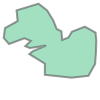

In [94]:
polygon = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -4.544537934435823,
              48.884502899654166
            ],
            [
              -5.348340028227227,
              48.217743011735024
            ],
            [
              -1.792586469989999,
              46.040475246546805
            ],
            [
              -1.7912535680239614,
              43.48540641539168
            ],
            [
              4.3313760969000725,
              42.82956276957751
            ],
            [
              8.180752968129212,
              43.25065655732513
            ],
            [
              9.705676436402001,
              45.95176316825501
            ],
            [
              9.917627010220514,
              48.7954416254324
            ],
            [
              9.988182099544048,
              51.431258741466564
            ],
            [
              9.803011551238228,
              53.15105084500465
            ],
            [
              7.371951979668552,
              54.51118316041584
            ],
            [
              4.408043781492722,
              53.34972701112633
            ],
            [
              3.602026527032706,
              52.0166775019853
            ],
            [
              2.1856315966395243,
              51.456031885361085
            ],
            [
              1.997906177622184,
              53.437165214319094
            ],
            [
              0.9045306707178895,
              53.98354481068105
            ],
            [
              0.1420615919404895,
              55.92063325076549
            ],
            [
              -1.2682323639551782,
              58.21734292594468
            ],
            [
              -3.2473243320318375,
              59.764117799207924
            ],
            [
              -8.26586107344869,
              58.240235900230886
            ],
            [
              -8.016392196017478,
              55.79387055914452
            ],
            [
              -10.910916145133797,
              54.18339882243106
            ],
            [
              -11.211797635408345,
              51.92640299508895
            ],
            [
              -9.997687592010237,
              50.53817230382802
            ],
            [
              -6.4722925978423405,
              51.8537089435236
            ],
            [
              -5.014515186726385,
              51.25234081632712
            ],
            [
              -6.263244574555841,
              50.037246654143786
            ],
            [
              -5.2258019276055165,
              49.611236956500704
            ],
            [
              -1.4932905375772805,
              50.18954912363259
            ],
            [
              -4.544537934435823,
              48.884502899654166
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

import shapely
polygon = shapely.geometry.Polygon(polygon["features"][0]["geometry"]["coordinates"][0])
polygon

In [97]:
from shapely.geometry import box
import folium
import geopandas as gpd
import pandas as pd

region_of_interest_WGS84bbox_bbox = (-20.830078,39.571822,25.664063,59.756395)
zoomlevels = [4,]

shapely.prepare(polygon)

def plot_bounding_box(m, bbox, **kwargs):
    bounding_box_df = gpd.GeoDataFrame(pd.DataFrame({"geometry" : [box(*bbox),]}), geometry = "geometry", crs = "WGS84")
    return bounding_box_df.explore(style_kwds=dict(**kwargs, fill = False), m = m)

def plot_polygon(m, poly, name, **kwargs):
    bounding_box_df = gpd.GeoDataFrame(pd.DataFrame({"geometry" : [poly,]}), geometry = "geometry", crs = "WGS84")
    return bounding_box_df.explore(style_kwds=dict(**kwargs, fill = False), m = m, name = name)
    

# Make a geopandas data frame so we can plot the bounding box, copy the crs over
polygon_df = gpd.GeoDataFrame(pd.DataFrame({"geometry" : [polygon,]}), geometry = "geometry", crs = "WGS84")
m = polygon_df.explore(style_kwds=dict(color="black", fill = False), name = "Bounding Polygon")

from itertools import cycle
zoomlevels = [4,5,6,7,8]
zoomlevels = [6,]
colors = cycle(["blue", "red", "green"])

def mercator(tile):



for z, color in zip(zoomlevels, colors):
    tile_bbox = WGS84bbox_to_enclosing_tile_bbox(region_of_interest_WGS84bbox_bbox, zoomlevel = z)

    tiles = list(enumerate_tiles(tile_bbox, zoomlevel = z))
    
    tiles_as_shapely = [box(*tile["WGS84_bounds"]) for tile in tiles]
    
    # Filter only tiles that overlap
    tiles = [t for t, s in zip(tiles, tiles_as_shapely) if not polygon.disjoint(s)]
    tiles_as_shapely = [s for s in tiles_as_shapely if not polygon.disjoint(s)]
    
    print(f"At zoom level {z}, {len(tiles_as_shapely)} tiles.")
    tiles_df = gpd.GeoDataFrame(pd.DataFrame({"tiles" : tiles, "geometry" : tiles_as_shapely}), geometry = "geometry", crs = "WGS84")
    tiles_df.explore(style_kwds=dict(color = color, fill = False), m = m, name = f"WGS84 zoom {z}", tooltip = "tiles")

    tiles_df = gpd.GeoDataFrame(pd.DataFrame({"tiles" : tiles, "geometry" : [box(mercator(t)) for t in tiles]}), geometry = "geometry", crs = "EPSG:900913")
    tiles_df.explore(style_kwds=dict(color = color, fill = False), m = m, name = f"Mercator zoom {z}", tooltip = "tiles")

folium.LayerControl().add_to(m)
m

At zoom level 6, 14 tiles.


In [8]:
# from PIL import Image, ImageOps
# from IPython.display import display
# from shapely.geometry import box


# def make_image_coord_mapper(bounds, image_size):
#     minx, miny = bounds[0]
#     rangex = bounds[1][0] - bounds[0][0]
#     rangey = bounds[1][1] - bounds[0][1]
#     def mapper(coord):
#         x, y = coord
#         outx = (x - minx) / rangex * image_size[0]
#         outy = (y - miny) / rangey * image_size[1]
#         return outx, outy
#     return mapper


# # (lat, lon) is (height, width)
# with Image.open("Mercator_projection_SW.jpg") as im:
#     image_geo_bounds=[[-82, -180], [82, 180]]
#     mapper = make_image_coord_mapper(image_geo_bounds, im.size)

#     print(f"image size: {im.size}")
#     print(f"geo bounds in image space should be image size: {mapper(image_geo_bounds[0]), mapper(image_geo_bounds[1])}")
    
#     box_geo_bounds = (21.943045533438166, 45.00000000000001, 40.979898069620155, 67.5)
#     box_geo_bounds = np.array([-82, -180, 0, 180])
#     box_image_bounds = np.array((*mapper(box_geo_bounds[:2]), *mapper(box_geo_bounds[2:])))
#     print(f"{box_geo_bounds=}")
#     print(f"{box_image_bounds=}")

#     # pil box is (left, upper, right, lower) coordinate system with (0, 0) in the upper left corner.
#     # within (0, 0, width, height)
#     image_box = box_image_bounds
#     print(f"proving image bounds to pillow: {image_box}")
    
#     tile = im.resize((256,256), resample=Image.Resampling.LANCZOS, box=image_box, reducing_gap=None)
#     display(tile)
#     tile.save("test_tile.jpg", "JPEG")

# m = folium.Map([37, 0], zoom_start=1)

# plot_bounding_box(m, box_geo_bounds)

# folium.raster_layers.ImageOverlay(
#     image="test_tile.jpg",
#     bounds=[[-82, 0], [-180, 180]],
#     opacity=0.5,
#     interactive=False,
#     cross_origin=False,
#     zindex=1,
#     mercator_project=True,
#     alt="Wikipedia File:Mercator projection SW.jpg",
# ).add_to(m)

# m

In [9]:
pip install h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [10]:
import xarray as xr



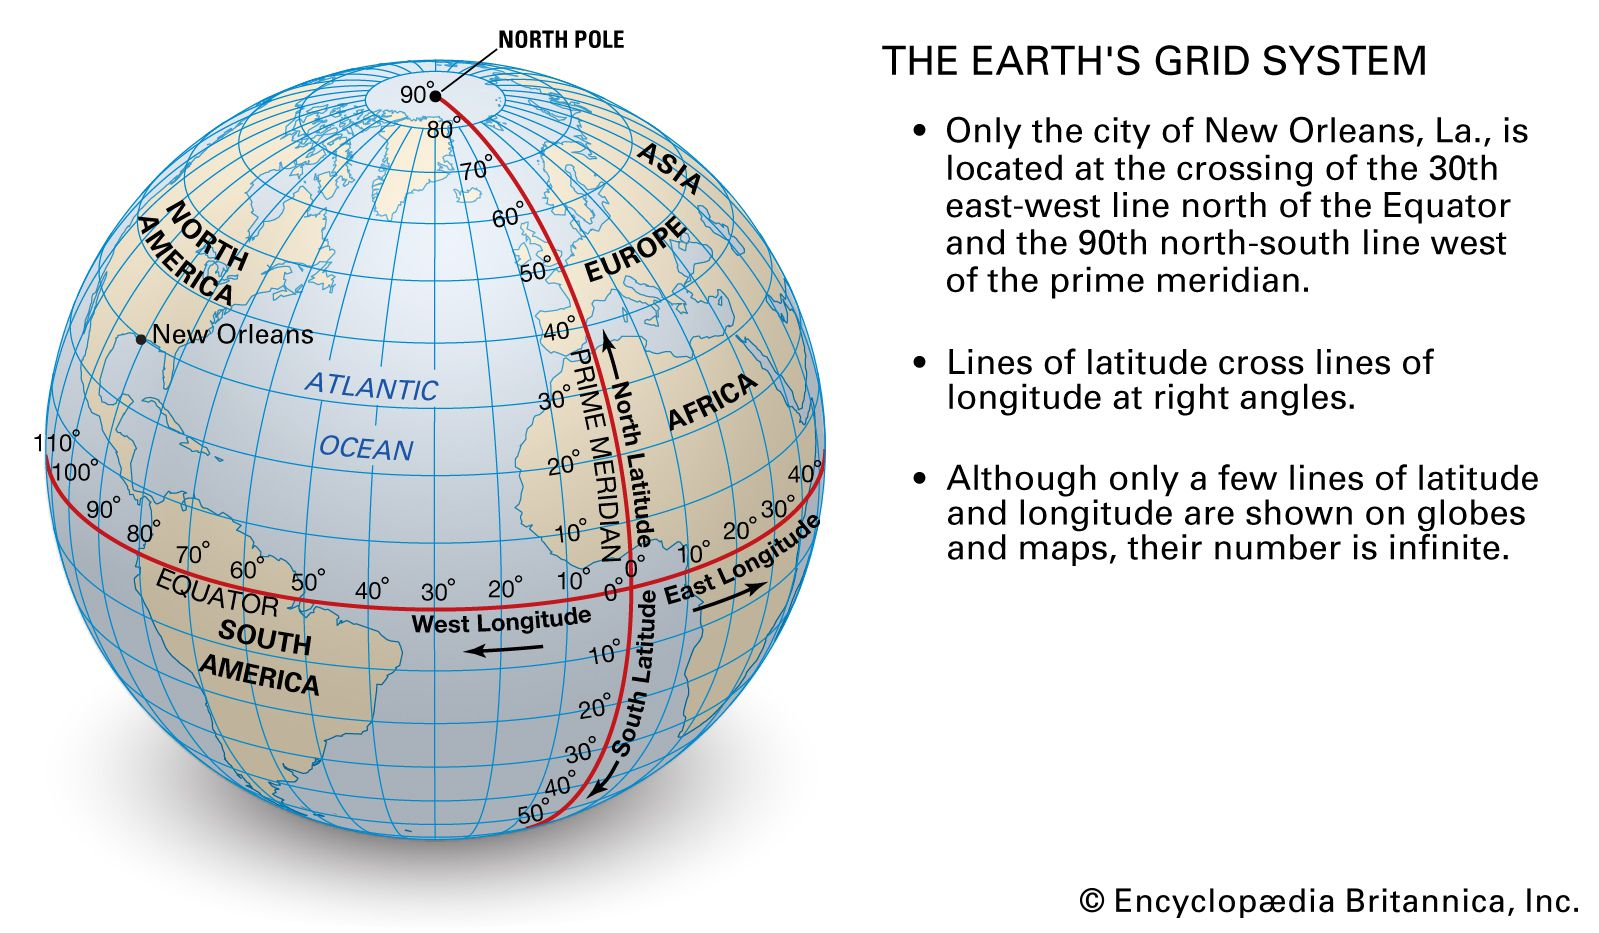

y.shape=(256,), x.shape=(256,)
non NaN entries in original 7896025
non NaN entries in filled 20350000
non NaN entries in interpolated 65536


Text(0.5, 1.0, 'Interpolated data')

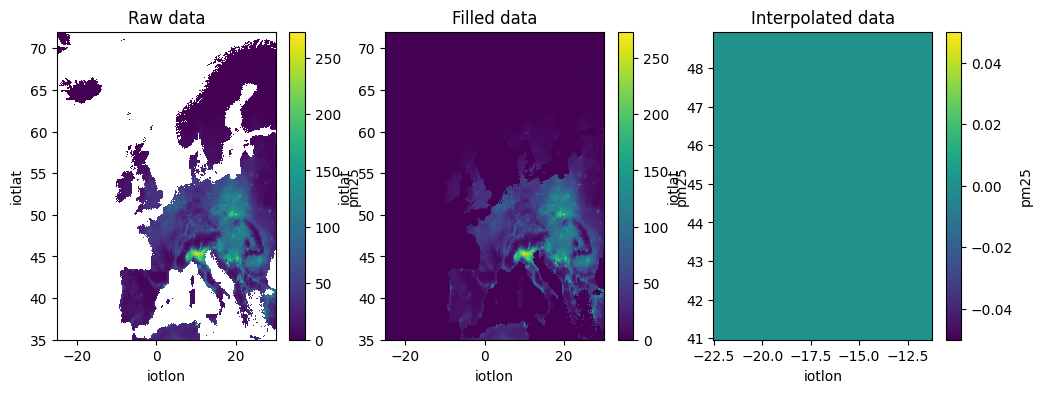

In [12]:
import xarray as xr
from matplotlib import pyplot as plt

tile = {'tilefilename': '5/20/14', 'mercator': (20, 17), 'google_quadkey': '30102', 'EPSG_900913_bounds': (5009377.085697312, -2504688.542848654, 6261721.357121639, -1252344.271424327), 'WGS84_bounds': (-21.943045533438166, 45.00000000000001, -11.178401873711772, 56.25)}
da = xr.open_dataarray('iot_cams_pm25_wmo_threshold.nc')
ds = da.to_dataset(name='pm25')

# new coords are 256x256 in mercator spherical meter coords (EPSG_900913)
miny, minx, maxy, maxx = tile['EPSG_900913_bounds']
x = np.linspace(minx, maxx, 256)
y = np.linspace(miny, maxy, 256)
print(f"{y.shape=}, {x.shape=}")
        
# relation between mercator and WGS84 coordinates
originShift = 2 * math.pi * 6378137 / 2.0
lon = (x / originShift) * 180.0
lat = (y / originShift) * 180.0
lat = 180 / math.pi * (2 * np.arctan( np.exp( lat * math.pi / 180.0)) - math.pi / 2.0)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

ds.pm25.plot(ax=axes[0], x = "iotlon", y = "iotlat")

axes[0].set_title("Raw data")

nan_map = np.zeros_like(ds.pm25)
nan_map[ np.isnan(ds.pm25) ] = 1

filled = ds.copy(deep=True)
filled.pm25.to_numpy()[ np.isnan(ds.pm25) ] = 0

# filled = xr.DataArray(filled,
#     dims=["iotlat", "iotlon"],
#     coords={"iotlat" : ds.coords["iotlat"], "iotlon": ds.coords.iotlon})

interpolated = filled.interp(iotlon=lon, iotlat=lat, method="nearest")

print("non NaN entries in original", np.count_nonzero(~np.isnan(ds.pm25)))
print("non NaN entries in filled", np.count_nonzero(~np.isnan(filled.pm25)))
print("non NaN entries in interpolated", np.count_nonzero(~np.isnan(interpolated.pm25)))


filled.pm25.plot(ax=axes[1], x="iotlon", y = "iotlat")
axes[1].set_title("Filled data")

interpolated.pm25.plot(ax=axes[2], x="iotlon", y = "iotlat")
axes[2].set_title("Interpolated data")

y.shape=(256,), x.shape=(256,)
{'tilefilename': '5/20/14', 'mercator': (20, 17), 'google_quadkey': '30102', 'EPSG_900913_bounds': (5009377.085697312, -2504688.542848654, 6261721.357121639, -1252344.271424327), 'WGS84_bounds': (-21.943045533438166, 45.00000000000001, -11.178401873711772, 56.25)}
np.min(lon)=-22.499999999999986, np.max(lon)=-11.249999999999993
np.min(lat)=40.979898069620155, np.max(lat)=48.922499263758255
ds.pm25.coords=Coordinates:
  * iotlon   (iotlon) float64 44kB -25.0 -24.98 -24.97 ... 29.98 29.99 30.0
  * iotlat   (iotlat) float64 30kB 35.01 35.02 35.02 35.03 ... 71.97 71.98 71.99
<xarray.Dataset> Size: 532kB
Dimensions:  (x: 256, y: 256)
Coordinates:
    iotlon   (x) float64 2kB -22.5 -22.46 -22.41 -22.37 ... -11.34 -11.29 -11.25
    iotlat   (y) float64 2kB 40.98 41.01 41.05 41.08 ... 48.84 48.86 48.89 48.92
  * x        (x) float64 2kB -2.505e+06 -2.5e+06 ... -1.257e+06 -1.252e+06
  * y        (y) float64 2kB 5.009e+06 5.014e+06 ... 6.257e+06 6.262e+06
Data vari

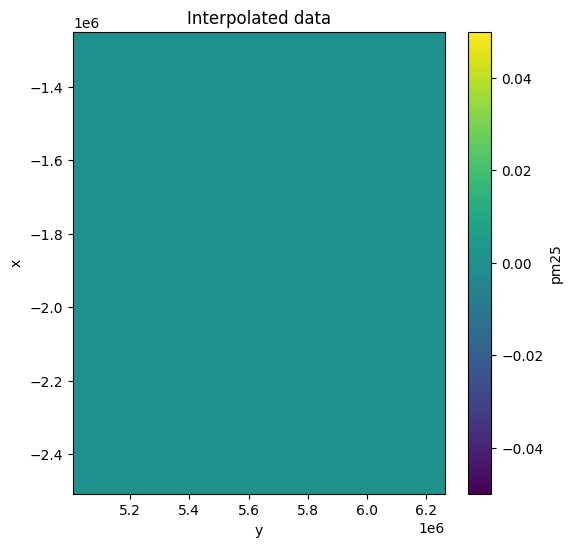

In [13]:
import rioxarray

# new coords are 256x256 in mercator spherical meter coords (EPSG_900913)
miny, minx, maxy, maxx = tile['EPSG_900913_bounds']
x = np.linspace(minx, maxx, 256)
y = np.linspace(miny, maxy, 256)
print(f"{y.shape=}, {x.shape=}")
        
# relation between mercator and WGS84 coordinates
originShift = 2 * math.pi * 6378137 / 2.0
lon = (x / originShift) * 180.0
lat = (y / originShift) * 180.0
lat = 180 / math.pi * (2 * np.arctan( np.exp( lat * math.pi / 180.0)) - math.pi / 2.0)

print(tile)
print(f"{np.min(lon)=}, {np.max(lon)=}")
print(f"{np.min(lat)=}, {np.max(lat)=}")


print(f'{ds.pm25.coords=}')

lat = xr.DataArray(lat,
    dims=["y"],
    coords={"y": y})


lon = xr.DataArray(
    lon,
    dims=["x"],
    coords={"x": x},
)

fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

interpolated = filled.interp(iotlon=lon, iotlat=lat)
print(interpolated)

print("NaN entries in filled", np.count_nonzero(np.isnan(filled.pm25)))
print("non NaN entries in interpolated", np.count_nonzero(~np.isnan(interpolated.pm25)))

interpolated.pm25.plot(ax=ax,)
ax.set_title("Interpolated data")

from PIL import Image
im = Image.fromarray(interpolated.pm25.to_numpy(), mode = "L")
im = im.convert("L")
im.save("test.png")

In [ ]:
ds.coords["iotlon"].min?

In [118]:
from shapely.geometry import box
import folium
import geopandas as gpd
import pandas as pd
from PIL import Image
from pathlib import Path

mercator = GlobalMercator()

def WGS84bbox_to_enclosing_tile_bbox(bbox, zoomlevel):
    lat, lon, latmax, lonmax = bbox
    tz = zoomlevel
    
    mx, my = mercator.LatLonToMeters( lat, lon )
    tminx, tminy = mercator.MetersToTile( mx, my, tz )
    
    mx, my = mercator.LatLonToMeters( latmax, lonmax )
    tmaxx, tmaxy = mercator.MetersToTile( mx, my, tz )
    
    return tminx, tminy, tmaxx, tmaxy
    

def enumerate_tiles(bbox, zoomlevel):    
    tminx, tminy, tmaxx, tmaxy = bbox
    tz = zoomlevel
    for ty in range(tminy, tmaxy+1):
        for tx in range(tminx, tmaxx+1):
            yield dict(
                tilefilename = f"{tz}/{tx}/{ty}",
                mercator = mercator.GoogleTile(tx, ty, tz),
                google_quadkey = mercator.QuadTree(tx, ty, tz),
                EPSG_900913_bounds = mercator.TileBounds( tx, ty, tz),
                WGS84_bounds = mercator.TileLatLonBounds( tx, ty, tz),
            )

da = xr.open_dataarray('iot_cams_pm25_wmo_threshold.nc')
ds = da.to_dataset(name='pm25')

filled = ds.copy(deep=True)
filled.pm25.to_numpy()[ np.isnan(ds.pm25) ] = 0

region_of_interest_WGS84bbox_bbox = (
        ds.coords["iotlon"].min().values,
        ds.coords["iotlat"].min().values,
        ds.coords["iotlon"].max().values,
        ds.coords["iotlat"].max().values,
       )

polygon = box(*region_of_interest_WGS84bbox_bbox)
shapely.prepare(polygon)

from itertools import cycle
zoomlevels = [0,1,2,3,4,5,6]
colors = cycle(["blue", "red", "green"])

def swizzle(b): return b[1], b[0], b[3], b[2]   

def extract_and_save_tile(tile, input_data, zoom, tilesize = 256):
    # Construct a tilesizextilesize grid of coords in EPSG_900913 coordinate space
    t = mercantile.tile(*tile['WGS84_bounds'][:2], zoom)
    mb = mercantile.xy_bounds(t)
    minx, miny, maxx, maxy = mb.left, mb.bottom, mb.right, mb.top
    
    minlon, minlat = mercantile.lnglat(minx, miny)
    maxlon, maxlat = mercantile.lnglat(maxx, maxy)

    y = np.linspace(minx, maxx, tilesize)
    x = np.linspace(miny, maxy, tilesize)
    lon = np.linspace(minlon, maxlon, tilesize)
    lat = np.linspace(minlat, maxlat, tilesize)
    
    # minx, miny, maxx, maxy = tile['EPSG_900913_bounds']
    # y = np.linspace(minx, maxx, tilesize)
    # x = np.linspace(miny, maxy, tilesize)
            
    # # Construct the corresponding WGS84 coordinates
    # originShift = 2 * math.pi * 6378137 / 2.0
    # lon = (x / originShift) * 180.0
    # lat = 180 / math.pi * (2 * np.arctan( np.exp( (y / originShift) * math.pi)) - math.pi / 2.0)

    lat = xr.DataArray(lat, dims=["x"], coords={"x": x})
    lon = xr.DataArray(lon, dims=["y"],coords={"y": y},)

    interpolated = input_data.interp(iotlon=lon, iotlat=lat, method="nearest")

    arr = interpolated.pm25.to_numpy()
    arr = np.clip(arr, 0, 255)
    arr = np.int8(arr)
    
    im = Image.fromarray(arr, mode = "L")
                 
    path = Path("tiles") / str(t.z) / str(t.x) / f"{t.y}.jpg"
    # print(path, path.parent)
    path.parent.mkdir(parents=True, exist_ok = True)
    im.save(path)
    # im.show()

from tqdm import tqdm

m = folium.Map()

for z, color in zip(zoomlevels, colors):

        
    tile_bbox = WGS84bbox_to_enclosing_tile_bbox(region_of_interest_WGS84bbox_bbox, zoomlevel = z)

    tiles = list(enumerate_tiles(tile_bbox, zoomlevel = z))
    tiles_as_shapely = [box(*tile["WGS84_bounds"]) for tile in tiles]
    
    # Filter only tiles that overlap
    tiles = [t for t,s in zip(tiles, tiles_as_shapely) if not polygon.disjoint(s)]
    tiles_as_shapely = [t for t in tiles_as_shapely if not polygon.disjoint(t)]

    tiles_df = gpd.GeoDataFrame(pd.DataFrame({"tiles" : tiles, "geometry" : tiles_as_shapely}), geometry = "geometry", crs = "WGS84")
    tiles_df.explore(style_kwds=dict(color = color, fill = False), m = m, name = f"Zoom level {z}", tooltip = "tiles")

    def mercator_box(tile):
        b = tile["EPSG_900913_bounds"]
        return box(*b)
        
    tiles_df = gpd.GeoDataFrame(pd.DataFrame({"tiles" : tiles, "geometry" : [mercator_box(tile) for tile in tiles]}), geometry = "geometry", crs = "EPSG:3857")
    tiles_df.explore(style_kwds=dict(color = color, fill = False), m = m, name = f"Zoom level {z}", tooltip = "tiles")

    for tile in tqdm(tiles):
        extract_and_save_tile(tile, input_data = filled, zoom=z, tilesize = 256)

    
    
m

  0%|                                                                    | 0/1 [00:00<?, ?it/s]/var/folders/kh/l7xgsyks5mz4b4q71_dngny40000gn/T/ipykernel_59757/539730289.py:88: RuntimeWarning: invalid value encountered in cast
  arr = np.int8(arr)
  0%|                                                                    | 0/2 [00:00<?, ?it/s]/var/folders/kh/l7xgsyks5mz4b4q71_dngny40000gn/T/ipykernel_59757/539730289.py:88: RuntimeWarning: invalid value encountered in cast
  arr = np.int8(arr)
  0%|                                                                    | 0/2 [00:00<?, ?it/s]/var/folders/kh/l7xgsyks5mz4b4q71_dngny40000gn/T/ipykernel_59757/539730289.py:88: RuntimeWarning: invalid value encountered in cast
  arr = np.int8(arr)
  0%|                                                                    | 0/4 [00:00<?, ?it/s]/var/folders/kh/l7xgsyks5mz4b4q71_dngny40000gn/T/ipykernel_59757/539730289.py:88: RuntimeWarning: invalid value encountered in cast
  arr = np.int8(arr)
  0%|   

In [300]:
from shapely.geometry import box
import folium
import geopandas as gpd
import pandas as pd
from PIL import Image
from pathlib import Path
import shutil
from pyproj import Transformer
from matplotlib import colormaps as cmaps

cmap = cmaps["turbo"]

webmercator_to_wsg84 = Transformer.from_crs("EPSG:3857", "EPSG:4326",  always_xy=True)

da = xr.open_dataarray('iot_cams_pm25_wmo_threshold.nc')
ds = da.to_dataset(name='pm25')

ds["pm25"] = ds.pm25 / ds.pm25.max()

filled = ds.copy(deep=True)
filled.pm25.to_numpy()[ np.isnan(ds.pm25) ] = 0

mask = (~ds.pm25.isnull()) * 1.0

region_of_interest_WGS84bbox_bbox = (
        ds.coords["iotlon"].min().values,
        ds.coords["iotlat"].min().values,
        ds.coords["iotlon"].max().values,
        ds.coords["iotlat"].max().values,
       ) 

def extract_and_save_tile(tile, input_data, mask, tilesize = 256):
    # Get the bounds of the tile
    mb = mercantile.xy_bounds(tile)
    minx, miny, maxx, maxy = mb.left, mb.bottom, mb.right, mb.top

    # Construct a uniform grid in mercator coords
    x = np.linspace(minx, maxx, tilesize)
    y = np.linspace(miny, maxy, tilesize)
    
    # Construct the coressponding warped grid in WSG84 coords
    lon, lat = webmercator_to_wsg84.transform(x, y)
    
    lat = xr.DataArray(lat, dims=["y"], coords={"y": y})
    lon = xr.DataArray(lon, dims=["x"],coords={"x": x},)

    interpolated = input_data.interp(iotlon=lon, iotlat=lat, method = "linear")
    interpolated_mask = mask.interp(iotlon=lon, iotlat=lat, method = "nearest")

    arr = interpolated.pm25.to_numpy().T[::-1, ::]
    interpolated_mask = (interpolated_mask.to_numpy().T[::-1, ::] * 255)

    arr[np.isnan(arr)] = 0 
    interpolated_mask[np.isnan(interpolated_mask)] = 0
    colors = cmap(arr, alpha = interpolated_mask, bytes = True)
    
    im = Image.fromarray(colors, mode = "RGBA")
                 
    path = Path("tiles") / str(tile.z) / str(tile.x) / f"{tile.y}.png"
    path.parent.mkdir(parents=True, exist_ok = True)
    im.save(path)
    # im.show()

from tqdm import tqdm

m = folium.Map()

if Path("./tiles").exists(): shutil.rmtree("./tiles")
zooms = range(0,7)
for tile in tqdm(list(mercantile.tiles(*region_of_interest_WGS84bbox_bbox, zooms))):
    extract_and_save_tile(tile, input_data = filled, mask = mask)
    # break



100%|████████████████████████████████████████████████████████| 214/214 [00:48<00:00,  4.41it/s]


In [273]:
from matplotlib import colormaps as cmaps

cmap = cmaps["turbo"]

In [281]:
arr = np.array([1,2,3])
mask = np.array([1,2,3])

colors = cmap(arr)
colors[:, 3] = mask

colors.shape

(3, 4)

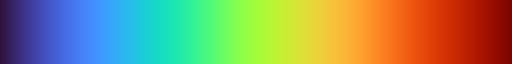

In [295]:
t = cmaps["turbo"]
t

In [297]:
t?

Signature:      t(X, alpha=None, bytes=False)
Type:           ListedColormap
String form:    <matplotlib.colors.ListedColormap object at 0x2af447490>
File:           ~/micromamba/envs/ionbeam/lib/python3.11/site-packages/matplotlib/colors.py
Docstring:     
Colormap object generated from a list of colors.

This may be most useful when indexing directly into a colormap,
but it can also be used to generate special colormaps for ordinary
mapping.

Parameters
----------
colors : list, array
    Sequence of Matplotlib color specifications (color names or RGB(A)
    values).
name : str, optional
    String to identify the colormap.
N : int, optional
    Number of entries in the map. The default is *None*, in which case
    there is one colormap entry for each element in the list of colors.
    If ::

        N < len(colors)

    the list will be truncated at *N*. If ::

        N > len(colors)

    the list will be extended by repetition.
Init docstring:
Parameters
----------
name : str
    